In [2]:
import torch
import models
import os
from Dataset import Dataset
from torch.autograd.variable import Variable
import numpy as np
from util_moduls.Utils import get_device
from lib.NCEAverage import NCEAverage
import matplotlib.pyplot as plt
from test import NN, kNN
from scipy import misc
import cPickle as pickle
import h5py

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [1]:
import os
os.getcwd()

'/home/sascha/secondDisk/balas_training/lemniscate_reproduce_bdd_vis'

In [3]:
batch_size = 32
workers = 0
gpu = 1
low_dim = 128
topk = 20

In [3]:
def resize2d(img, size):
    return (torch.nn.functional.adaptive_avg_pool2d(Variable(img,requires_grad=False), size)).data

In [3]:
low_dim = 128
checkpoint = torch.load('./old_checkpoints/checkpoint_epoch80000.pth.tar')
model = models.__dict__[checkpoint['arch']](low_dim=low_dim)
model = model.cuda()

In [4]:
state_dict = checkpoint['state_dict']

model = torch.nn.DataParallel(model).to('cuda')

print('epoch: {}'.format(checkpoint['epoch']))
epoch = checkpoint['epoch']
lemniscate = checkpoint['lemniscate']
# load params
model.load_state_dict(state_dict)

epoch: 80000


/usr/local/lib/python2.7/dist-packages/torch/nn/parallel/data_parallel.py:24: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [ ]:
print('setting up train dataset')
train_dataset = Dataset('/data/dataset/full_train_set_v3.hdf5', n_frames=6, frame_gap=4,preload_to_mem = False)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, #(train_sampler is None), 
    num_workers=workers)

In [4]:
print('setting up val dataset')
val_dataset = Dataset('/data/dataset/full_val_set_v3.hdf5', n_frames=6, frame_gap=4,preload_to_mem = False)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=workers)

setting up val dataset
Loading /data/dataset/full_val_set_v3.hdf5
The file exists: True


In [6]:
from collections import defaultdict
import time
debug = True

In [ ]:

retrieval_dict = defaultdict(lambda:defaultdict())
trainFeatures = lemniscate.memory.t()
trainLabels = torch.LongTensor(train_loader.dataset.train_labels).cuda()

for batch_idx, (input_imgs, targets, indexes) in enumerate(val_loader):
    
    start_time = time.time()
    
    targets = targets.cuda(async=True)
    indexes = indexes.cuda(async=True)
    batchSize = input_imgs.size(0)

    og_targets = targets.clone().cpu().numpy()

    input_imgs = input_imgs[:,0:9,:,:] #extract only img 1 through 3
    targets = Variable(torch.from_numpy(np.zeros((len(indexes),
                                                  3,
                                                  targets.shape[2]))).type(torch.FloatTensor))

    features = model(input_imgs, targets) # Here the targets have to be removed in a future version
    
    dist = torch.mm(features, trainFeatures)

    yd, yi = dist.topk(topk, dim=1, largest=True, sorted=True)
    candidates = trainLabels.view(1,-1).expand(batchSize, -1)
    retrieval = torch.gather(candidates, 1, yi)

    retrieval = retrieval.narrow(1, 0, topk).clone().cpu().numpy()#.view(-1)
    yd = yd.narrow(1, 0, topk)

    image_steering_labels = []
    indexes = indexes.cpu().numpy()

    for batch_id in range(input_imgs.size()[0]):
    
        actions = []
        retrieval_ids = []
        file_keys= []

        batch_i_steer = og_targets[batch_id,:] # 6x6

        image_steering_label_future = 0

        for top_id in range(topk):
            ret_ind = int(retrieval[batch_id, top_id])
            
            file_key = train_loader.dataset.get_data_point(ret_ind).data_point()['file_key']
            action_label = train_loader.dataset.get_data_point(ret_ind).data_point()['actions']
            
            file_keys.append(file_key)
            actions.append(action_label)
            retrieval_ids.append(ret_ind)
        
        retrieval_dict[indexes[batch_id]]['actions'] = np.array(actions)
        retrieval_dict[indexes[batch_id]]['file_keys'] = str(file_keys)
        retrieval_dict[indexes[batch_id]]['retrieval_ids'] = np.array(retrieval_ids)
    
    print "Batch finished after {}. Batch {} of {}".format(time.time()- start_time, batch_idx,len(val_loader))

with h5py.File('eval_data.h5py','w') as h5file:
    for dict_key in retrieval_dict.keys():
        h5file.create_dataset(name=str(dict_key)+'/'+'actions',data=retrieval_dict[dict_key]['actions'])
        h5file.create_dataset(name=str(dict_key)+'/'+'file_keys',data=retrieval_dict[dict_key]['file_keys'])
        h5file.create_dataset(name=str(dict_key)+'/'+'retrieval_ids',data=retrieval_dict[dict_key]['retrieval_ids'])


print "Finished"

Batch finished after 3.63155388832. Batch 0 of 6221
Batch finished after 3.59845805168. Batch 1 of 6221
Batch finished after 3.73048114777. Batch 2 of 6221
Batch finished after 3.65869998932. Batch 3 of 6221
Batch finished after 3.68163895607. Batch 4 of 6221
Batch finished after 3.63469409943. Batch 5 of 6221
Batch finished after 3.50504398346. Batch 6 of 6221
Batch finished after 3.75378608704. Batch 7 of 6221
Batch finished after 3.74687194824. Batch 8 of 6221
Batch finished after 3.7831029892. Batch 9 of 6221
Batch finished after 3.79295706749. Batch 10 of 6221
Batch finished after 3.74232697487. Batch 11 of 6221
Batch finished after 3.89581012726. Batch 12 of 6221
Batch finished after 3.74334597588. Batch 13 of 6221
Batch finished after 3.56765007973. Batch 14 of 6221
Batch finished after 3.59287786484. Batch 15 of 6221
Batch finished after 3.75041389465. Batch 16 of 6221
Batch finished after 3.59733605385. Batch 17 of 6221
Batch finished after 3.66737699509. Batch 18 of 6221
Batc

Batch finished after 4.13440394402. Batch 154 of 6221
Batch finished after 3.99940180779. Batch 155 of 6221
Batch finished after 3.73982405663. Batch 156 of 6221
Batch finished after 3.8842010498. Batch 157 of 6221
Batch finished after 4.07379198074. Batch 158 of 6221
Batch finished after 3.80425310135. Batch 159 of 6221
Batch finished after 4.0350959301. Batch 160 of 6221
Batch finished after 3.78186011314. Batch 161 of 6221
Batch finished after 3.8726670742. Batch 162 of 6221
Batch finished after 3.86875510216. Batch 163 of 6221
Batch finished after 4.12750792503. Batch 164 of 6221
Batch finished after 3.82985496521. Batch 165 of 6221
Batch finished after 3.92580580711. Batch 166 of 6221
Batch finished after 3.96634888649. Batch 167 of 6221
Batch finished after 3.89747595787. Batch 168 of 6221
Batch finished after 4.03381204605. Batch 169 of 6221
Batch finished after 3.90898895264. Batch 170 of 6221
Batch finished after 3.77710103989. Batch 171 of 6221
Batch finished after 3.86276721

Batch finished after 31.2896709442. Batch 307 of 6221
Batch finished after 4.02880311012. Batch 308 of 6221
Batch finished after 4.06399607658. Batch 309 of 6221
Batch finished after 4.10530090332. Batch 310 of 6221
Batch finished after 4.09151291847. Batch 311 of 6221
Batch finished after 4.16579008102. Batch 312 of 6221
Batch finished after 4.11242389679. Batch 313 of 6221
Batch finished after 4.06981515884. Batch 314 of 6221
Batch finished after 4.08412003517. Batch 315 of 6221
Batch finished after 4.14285302162. Batch 316 of 6221
Batch finished after 3.97394895554. Batch 317 of 6221
Batch finished after 3.78769111633. Batch 318 of 6221
Batch finished after 3.85289001465. Batch 319 of 6221
Batch finished after 3.99519395828. Batch 320 of 6221
Batch finished after 3.77009105682. Batch 321 of 6221
Batch finished after 3.85991191864. Batch 322 of 6221
Batch finished after 3.96844792366. Batch 323 of 6221
Batch finished after 4.03330492973. Batch 324 of 6221
Batch finished after 3.66849

Batch finished after 4.08389592171. Batch 460 of 6221
Batch finished after 4.08763098717. Batch 461 of 6221
Batch finished after 4.20799899101. Batch 462 of 6221
Batch finished after 3.90620803833. Batch 463 of 6221
Batch finished after 3.90363693237. Batch 464 of 6221
Batch finished after 4.14544987679. Batch 465 of 6221
Batch finished after 3.95982480049. Batch 466 of 6221
Batch finished after 4.33667683601. Batch 467 of 6221
Batch finished after 4.14944505692. Batch 468 of 6221
Batch finished after 3.94348502159. Batch 469 of 6221
Batch finished after 4.01970100403. Batch 470 of 6221
Batch finished after 4.11455583572. Batch 471 of 6221
Batch finished after 3.83026194572. Batch 472 of 6221
Batch finished after 4.07359099388. Batch 473 of 6221
Batch finished after 3.96829009056. Batch 474 of 6221
Batch finished after 4.00783896446. Batch 475 of 6221
Batch finished after 3.96257996559. Batch 476 of 6221
Batch finished after 3.98501896858. Batch 477 of 6221
Batch finished after 3.98270

Batch finished after 4.2031121254. Batch 612 of 6221
Batch finished after 4.10661697388. Batch 613 of 6221
Batch finished after 3.92376112938. Batch 614 of 6221
Batch finished after 4.02184700966. Batch 615 of 6221
Batch finished after 4.0771188736. Batch 616 of 6221
Batch finished after 4.15688300133. Batch 617 of 6221
Batch finished after 4.08132314682. Batch 618 of 6221
Batch finished after 4.00517392159. Batch 619 of 6221
Batch finished after 3.66375088692. Batch 620 of 6221
Batch finished after 4.1323120594. Batch 621 of 6221
Batch finished after 3.95011806488. Batch 622 of 6221
Batch finished after 3.88383316994. Batch 623 of 6221
Batch finished after 4.08426785469. Batch 624 of 6221
Batch finished after 3.85216808319. Batch 625 of 6221
Batch finished after 3.78088998795. Batch 626 of 6221
Batch finished after 4.03497886658. Batch 627 of 6221
Batch finished after 4.01659607887. Batch 628 of 6221
Batch finished after 3.92973089218. Batch 629 of 6221
Batch finished after 4.01382088

Batch finished after 3.80373501778. Batch 764 of 6221
Batch finished after 3.93092393875. Batch 765 of 6221
Batch finished after 3.78769993782. Batch 766 of 6221
Batch finished after 3.97224593163. Batch 767 of 6221
Batch finished after 3.99591588974. Batch 768 of 6221
Batch finished after 3.96162891388. Batch 769 of 6221
Batch finished after 3.80823111534. Batch 770 of 6221
Batch finished after 3.84453892708. Batch 771 of 6221
Batch finished after 3.92416620255. Batch 772 of 6221
Batch finished after 4.00585389137. Batch 773 of 6221
Batch finished after 3.82117080688. Batch 774 of 6221
Batch finished after 3.82216215134. Batch 775 of 6221
Batch finished after 3.75517582893. Batch 776 of 6221
Batch finished after 3.78629183769. Batch 777 of 6221
Batch finished after 4.01556897163. Batch 778 of 6221
Batch finished after 3.74697518349. Batch 779 of 6221
Batch finished after 3.9443500042. Batch 780 of 6221
Batch finished after 4.02933192253. Batch 781 of 6221
Batch finished after 3.821599

Batch finished after 3.9380698204. Batch 916 of 6221
Batch finished after 3.8738861084. Batch 917 of 6221
Batch finished after 4.04893088341. Batch 918 of 6221
Batch finished after 4.02491784096. Batch 919 of 6221
Batch finished after 4.04779005051. Batch 920 of 6221
Batch finished after 4.10005807877. Batch 921 of 6221
Batch finished after 4.01834082603. Batch 922 of 6221
Batch finished after 4.17906308174. Batch 923 of 6221
Batch finished after 4.14504218102. Batch 924 of 6221
Batch finished after 3.90221595764. Batch 925 of 6221
Batch finished after 4.40447282791. Batch 926 of 6221
Batch finished after 4.38505911827. Batch 927 of 6221
Batch finished after 4.38139104843. Batch 928 of 6221
Batch finished after 4.10976099968. Batch 929 of 6221
Batch finished after 4.04968905449. Batch 930 of 6221
Batch finished after 3.96322488785. Batch 931 of 6221
Batch finished after 4.11006498337. Batch 932 of 6221
Batch finished after 4.24464893341. Batch 933 of 6221
Batch finished after 4.2254829

Batch finished after 4.3017911911. Batch 1067 of 6221
Batch finished after 4.38672709465. Batch 1068 of 6221
Batch finished after 4.18077993393. Batch 1069 of 6221
Batch finished after 4.33837199211. Batch 1070 of 6221
Batch finished after 4.108314991. Batch 1071 of 6221
Batch finished after 4.2520198822. Batch 1072 of 6221
Batch finished after 4.1724178791. Batch 1073 of 6221
Batch finished after 4.00503587723. Batch 1074 of 6221
Batch finished after 3.96283602715. Batch 1075 of 6221
Batch finished after 4.34389305115. Batch 1076 of 6221
Batch finished after 4.25732493401. Batch 1077 of 6221
Batch finished after 4.237596035. Batch 1078 of 6221
Batch finished after 4.02155685425. Batch 1079 of 6221
Batch finished after 4.04063200951. Batch 1080 of 6221
Batch finished after 4.26424193382. Batch 1081 of 6221
Batch finished after 4.39126992226. Batch 1082 of 6221
Batch finished after 4.1671462059. Batch 1083 of 6221
Batch finished after 4.35096693039. Batch 1084 of 6221
Batch finished aft

Batch finished after 4.1170899868. Batch 1217 of 6221
Batch finished after 3.91238808632. Batch 1218 of 6221
Batch finished after 3.97653079033. Batch 1219 of 6221
Batch finished after 4.02954912186. Batch 1220 of 6221
Batch finished after 4.00372004509. Batch 1221 of 6221
Batch finished after 4.15644598007. Batch 1222 of 6221
Batch finished after 4.14938688278. Batch 1223 of 6221
Batch finished after 3.91259789467. Batch 1224 of 6221
Batch finished after 3.89834594727. Batch 1225 of 6221
Batch finished after 3.9169678688. Batch 1226 of 6221
Batch finished after 3.97914600372. Batch 1227 of 6221
Batch finished after 3.98503708839. Batch 1228 of 6221
Batch finished after 3.94656300545. Batch 1229 of 6221
Batch finished after 4.25181388855. Batch 1230 of 6221
Batch finished after 3.96520805359. Batch 1231 of 6221
Batch finished after 4.06635713577. Batch 1232 of 6221
Batch finished after 3.92420005798. Batch 1233 of 6221
Batch finished after 4.24522805214. Batch 1234 of 6221
Batch finish

Batch finished after 4.31855988503. Batch 1367 of 6221
Batch finished after 4.21533298492. Batch 1368 of 6221
Batch finished after 3.9890639782. Batch 1369 of 6221
Batch finished after 3.93572402. Batch 1370 of 6221
Batch finished after 4.07171297073. Batch 1371 of 6221
Batch finished after 4.1759250164. Batch 1372 of 6221
Batch finished after 4.26490402222. Batch 1373 of 6221
Batch finished after 4.2655620575. Batch 1374 of 6221
Batch finished after 3.98393297195. Batch 1375 of 6221
Batch finished after 4.07090497017. Batch 1376 of 6221
Batch finished after 3.99621105194. Batch 1377 of 6221
Batch finished after 3.98072695732. Batch 1378 of 6221
Batch finished after 4.49452400208. Batch 1379 of 6221
Batch finished after 3.75209403038. Batch 1380 of 6221
Batch finished after 4.01745080948. Batch 1381 of 6221
Batch finished after 4.00678491592. Batch 1382 of 6221
Batch finished after 4.13412117958. Batch 1383 of 6221
Batch finished after 3.87361311913. Batch 1384 of 6221
Batch finished a

Batch finished after 4.07626199722. Batch 1517 of 6221
Batch finished after 4.03220486641. Batch 1518 of 6221
Batch finished after 4.002409935. Batch 1519 of 6221
Batch finished after 3.77123594284. Batch 1520 of 6221
Batch finished after 4.00477099419. Batch 1521 of 6221
Batch finished after 3.86606192589. Batch 1522 of 6221
Batch finished after 4.05599594116. Batch 1523 of 6221


In [5]:
h5file = h5py.File('eval_data.h5py','r')

In [6]:
from natsort import natsorted
import cv2

In [18]:
[h5file['0']['actions'][i][0] for i in range(20)]

[array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 0., 1., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0.6, 0.4, 0. , 0. , 0. , 0. ], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0.6, 0.4, 0. , 0. , 0. , 0. ], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0., 0.], dtype=float32),
 array([0.6, 0.4, 0. , 0. , 0. , 0. ], dtype=float32)]

In [ ]:
# Testing of looking only at the variance of the raw decision of stopping
topk = 20 # Testing different amounts of NNs

variance_data = []
keys_len = len(h5file.keys())
for j, key in enumerate(natsorted(h5file.keys())):
    
    if j % 100 == 0:
        print "{}%".format((j*100.)/keys_len)
    
    variance_data.append({
    't0':  np.var([h5file[key]['actions'][i][0][0] for i in range(topk)]),
    't1':  np.var([h5file[key]['actions'][i][1][0] for i in range(topk)]),
    't2':  np.var([h5file[key]['actions'][i][2][0] for i in range(topk)]),
    't3':  np.var([h5file[key]['actions'][i][3][0] for i in range(topk)]),
    't4':  np.var([h5file[key]['actions'][i][4][0] for i in range(topk)]),
    't5':  np.var([h5file[key]['actions'][i][5][0] for i in range(topk)]),
    'val_images':  val_dataset.get_data_point(int(key)).data_point()['imgs'][2],
    'gt_action': val_dataset.get_data_point(int(key)).data_point()['actions'],
    'key' : key}
    )
    

0.0%
0.0502371192026%
0.100474238405%
0.150711357608%
0.200948476811%
0.251185596013%
0.301422715216%
0.351659834418%
0.401896953621%
0.452134072824%
0.502371192026%
0.552608311229%
0.602845430432%
0.653082549634%
0.703319668837%
0.75355678804%
0.803793907242%
0.854031026445%
0.904268145647%
0.95450526485%
1.00474238405%
1.05497950326%
1.10521662246%
1.15545374166%
1.20569086086%
1.25592798007%
1.30616509927%
1.35640221847%
1.40663933767%
1.45687645688%
1.50711357608%
1.55735069528%
1.60758781448%
1.65782493369%
1.70806205289%
1.75829917209%
1.80853629129%
1.8587734105%
1.9090105297%
1.9592476489%
2.00948476811%
2.05972188731%
2.10995900651%
2.16019612571%
2.21043324492%
2.26067036412%
2.31090748332%
2.36114460252%
2.41138172173%
2.46161884093%
2.51185596013%
2.56209307933%
2.61233019854%
2.66256731774%
2.71280443694%
2.76304155615%
2.81327867535%
2.86351579455%
2.91375291375%
2.96399003296%
3.01422715216%
3.06446427136%
3.11470139056%
3.16493850977%
3.21517562897%
3.26541274817%
3.315

27.6304155615%
27.6806526807%
27.7308897999%
27.7811269191%
27.8313640383%
27.8816011575%
27.9318382767%
27.9820753959%
28.0323125151%
28.0825496343%
28.1327867535%
28.1830238727%
28.2332609919%
28.2834981111%
28.3337352303%
28.3839723495%
28.4342094687%
28.4844465879%
28.5346837071%
28.5849208263%
28.6351579455%
28.6853950647%
28.7356321839%
28.7858693031%
28.8361064223%
28.8863435415%
28.9365806607%
28.9868177799%
29.0370548991%
29.0872920183%
29.1375291375%
29.1877662567%
29.2380033759%
29.2882404951%
29.3384776143%
29.3887147335%
29.4389518527%
29.4891889719%
29.5394260912%
29.5896632104%
29.6399003296%
29.6901374488%
29.740374568%
29.7906116872%
29.8408488064%
29.8910859256%
29.9413230448%
29.991560164%
30.0417972832%
30.0920344024%
30.1422715216%
30.1925086408%
30.24274576%
30.2929828792%
30.3432199984%
30.3934571176%
30.4436942368%
30.493931356%
30.5441684752%
30.5944055944%
30.6446427136%
30.6948798328%
30.745116952%
30.7953540712%
30.8455911904%
30.8958283096%
30.9460654288%
3

55.3110682421%
55.3613053613%
55.4115424805%
55.4617795997%
55.5120167189%
55.5622538381%
55.6124909573%
55.6627280765%
55.7129651957%
55.7632023149%
55.8134394341%
55.8636765533%
55.9139136725%
55.9641507917%
56.0143879109%
56.0646250301%
56.1148621493%
56.1650992685%
56.2153363878%
56.265573507%
56.3158106262%
56.3660477454%
56.4162848646%
56.4665219838%
56.516759103%
56.5669962222%
56.6172333414%
56.6674704606%
56.7177075798%
56.767944699%
56.8181818182%
56.8684189374%
56.9186560566%
56.9688931758%
57.019130295%
57.0693674142%
57.1196045334%
57.1698416526%
57.2200787718%
57.270315891%
57.3205530102%
57.3707901294%
57.4210272486%
57.4712643678%
57.521501487%
57.5717386062%
57.6219757254%
57.6722128446%
57.7224499638%
57.772687083%
57.8229242022%
57.8731613214%
57.9233984406%
57.9736355598%
58.023872679%
58.0741097982%
58.1243469175%
58.1745840367%
58.2248211559%
58.2750582751%
58.3252953943%
58.3755325135%
58.4257696327%
58.4760067519%
58.5262438711%
58.5764809903%
58.6267181095%
58.

In [18]:
# First prototype. Check for the variance of t2
%matplotlib inline
import matplotlib.pyplot as plt

In [23]:
[data['t2'][0][0] for data in variance_data]

[1.0,
 1.0,
 1.0,
 0.6,
 0.2,
 0.0,
 0.0,
 0.0,
 0.8,
 1.0,
 0.0,
 1.0,
 0.8,
 0.0,
 0.8,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.2,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.4,
 1.0,
 0.0,
 0.0,
 0.0,
 0.8,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.2,
 0.8,
 0.0,
 1.0,
 1.0,
 0.2,
 0.0,
 1.0,
 0.6,
 1.0,
 1.0,
 0.0,
 1.0,
 0.2,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.4,
 0.0,
 0.0,
 0.6,
 0.6,
 0.0,
 1.0,
 1.0,
 0.0,
 0.4,
 0.8,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.4,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.8,
 1.0,
 1.0,
 1.0,
 1.0,
 0.2,
 1.0,
 1.0,
 0.2,
 1.0,
 0.6,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.6,
 1.0,
 1.0,
 0.6,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6,
 1.0,
 0.8,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8,
 0.8,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.4,
 1.0,
 0.6,
 1.0,
 0.6,
 0.6,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0

In [24]:
sort_indexes = np.argsort([data['t2'][0][0] for data in variance_data])

[1. 0. 0. 0. 0. 0.]


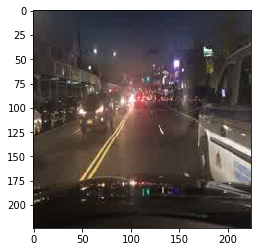

[1. 0. 0. 0. 0. 0.]


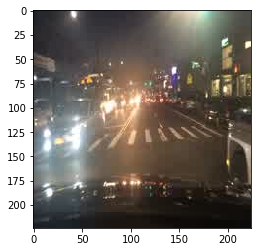

[1. 0. 0. 0. 0. 0.]


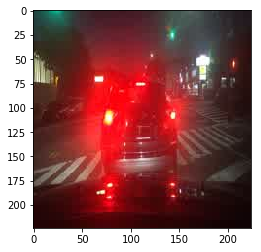

[1. 0. 0. 0. 0. 0.]


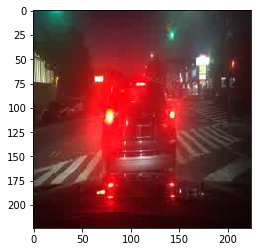

[1. 0. 0. 0. 0. 0.]


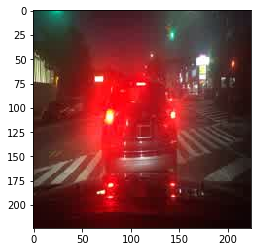

[1. 0. 0. 0. 0. 0.]


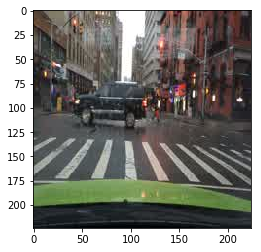

[1. 0. 0. 0. 0. 0.]


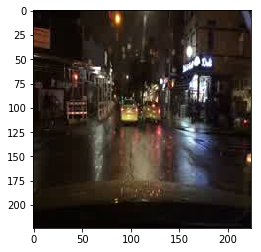

[1. 0. 0. 0. 0. 0.]


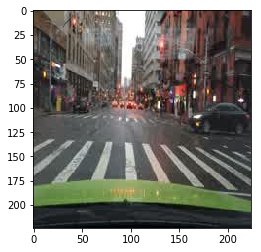

[1. 0. 0. 0. 0. 0.]


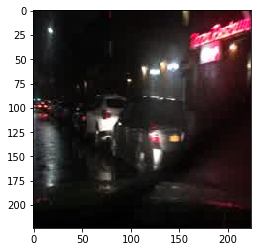

[1. 0. 0. 0. 0. 0.]


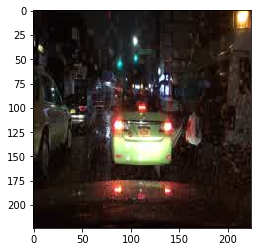

[1. 0. 0. 0. 0. 0.]


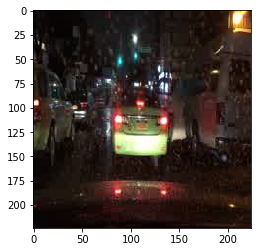

[1. 0. 0. 0. 0. 0.]


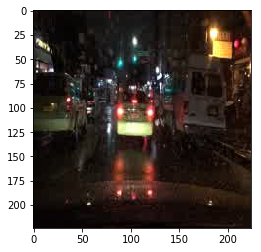

[1. 0. 0. 0. 0. 0.]


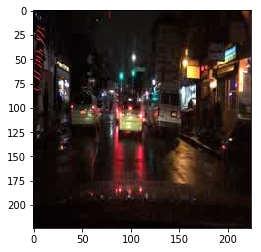

[1. 0. 0. 0. 0. 0.]


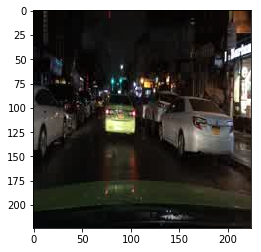

[1. 0. 0. 0. 0. 0.]


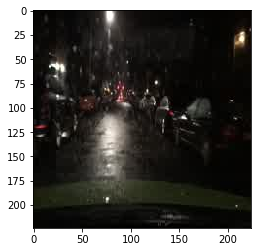

[1. 0. 0. 0. 0. 0.]


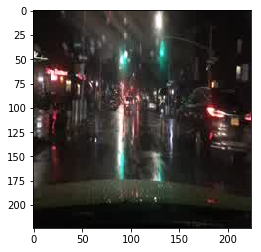

[1. 0. 0. 0. 0. 0.]


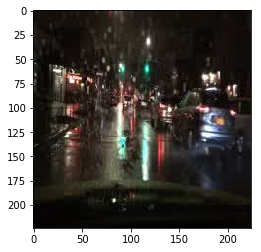

[1. 0. 0. 0. 0. 0.]


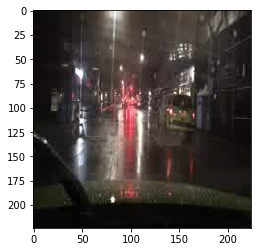

[1. 0. 0. 0. 0. 0.]


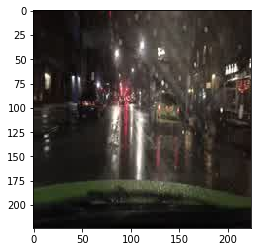

[1. 0. 0. 0. 0. 0.]


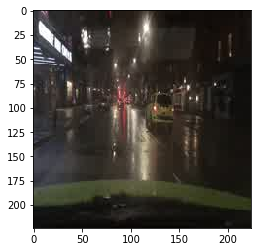

[1. 0. 0. 0. 0. 0.]


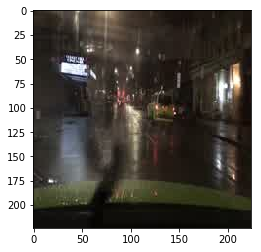

[1. 0. 0. 0. 0. 0.]


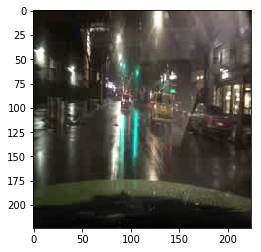

[1. 0. 0. 0. 0. 0.]


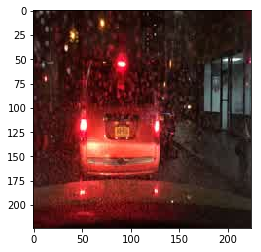

[1. 0. 0. 0. 0. 0.]


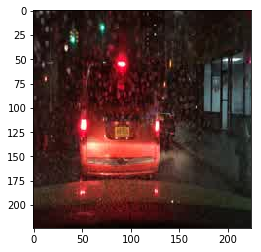

[1. 0. 0. 0. 0. 0.]


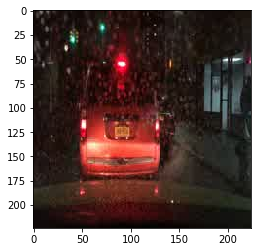

[1. 0. 0. 0. 0. 0.]


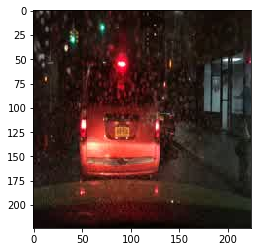

[1. 0. 0. 0. 0. 0.]


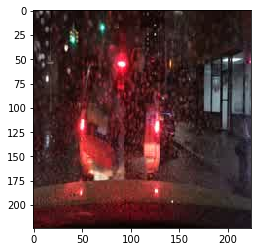

[1. 0. 0. 0. 0. 0.]


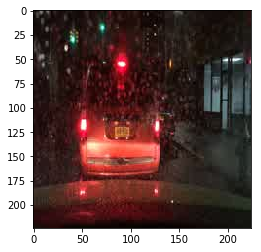

[1. 0. 0. 0. 0. 0.]


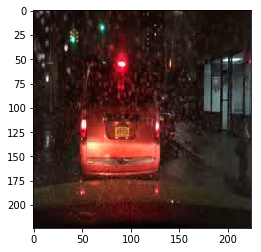

[1. 0. 0. 0. 0. 0.]


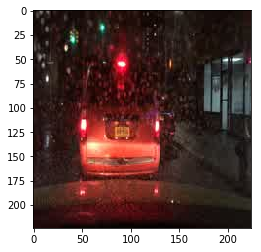

[1. 0. 0. 0. 0. 0.]


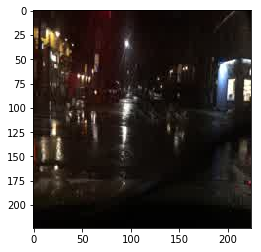

[1. 0. 0. 0. 0. 0.]


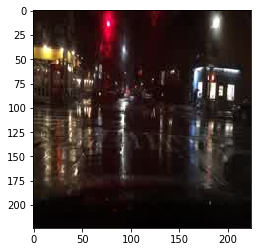

[1. 0. 0. 0. 0. 0.]


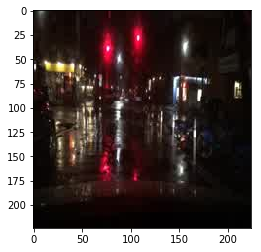

[1. 0. 0. 0. 0. 0.]


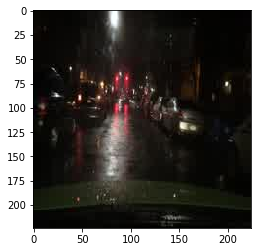

[1. 0. 0. 0. 0. 0.]


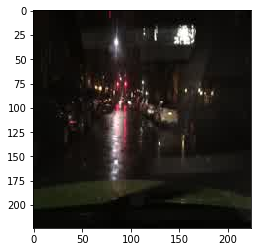

[1. 0. 0. 0. 0. 0.]


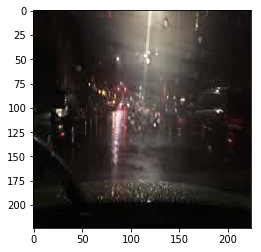

[1. 0. 0. 0. 0. 0.]


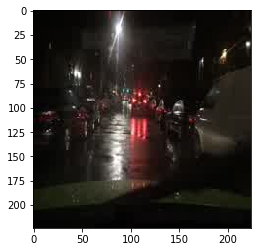

[1. 0. 0. 0. 0. 0.]


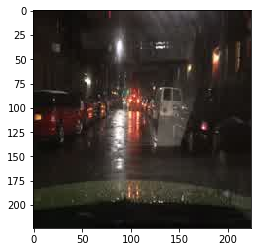

[1. 0. 0. 0. 0. 0.]


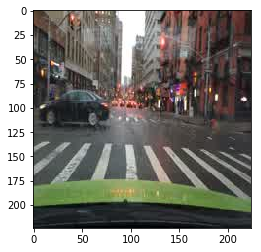

[1. 0. 0. 0. 0. 0.]


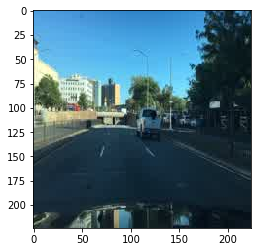

In [28]:
for i in range(len(sort_indexes)-40,len(sort_indexes)):
#for i in range(0,20):
    ret_index = sort_indexes[i]
    plt.imshow(cv2.cvtColor(np.array(variance_data)[ret_index]['val_images'],cv2.COLOR_BGR2RGB))
    print np.array(variance_data)[ret_index]['t2'][0]
    #print h5file[np.array(variance_data)[ret_index]['key']]['actions'][0][2]
    plt.show()

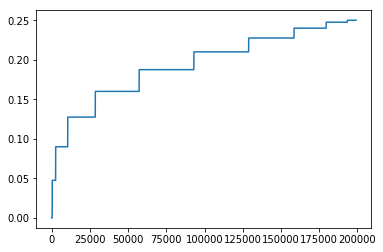

In [58]:
for t_key in ['t2']:
#t_key = 't2'
    sort_indexes = np.argsort(np.array([data[t_key] for data in variance_data]))
    plt.plot(np.array([data[t_key] for data in variance_data])[sort_indexes])


In [21]:
np.average([data['t0'] for data in variance_data])

0.12784511

In [22]:
np.average([data['t1'] for data in variance_data])

0.12544279

In [23]:
np.average([data['t2'] for data in variance_data])

0.12536016

In [24]:
np.average([data['t3'] for data in variance_data])

0.1282374

In [25]:
np.average([data['t4'] for data in variance_data])

0.13112965

In [26]:
np.average([data['t5'] for data in variance_data])

0.1344166